In [1]:
library(monocle)
library(Matrix)
pbmc<-readRDS('/data/work/final/03_anno/Osteoblast/Osteoblast.rds')
#pbmc<-readRDS('/data/work/paper/monocle/Tcell_sub_new.rds')
# 随机抽取一部分细胞

pbmc_subset<-subset(pbmc,downsample=5000,seed=123)

# 提取表达矩阵
expression_matrix <- pbmc_subset@assays$RNA@counts

# 提取细胞元数据（phenoData）
pheno_data <- pbmc_subset@meta.data

# 提取基因元数据（featureData）
gene_names <- rownames(pbmc_subset@assays$RNA@counts)
feature_data <- data.frame(gene_short_name = gene_names)
rownames(feature_data) <- gene_names

# 创建 CellDataSet
cds <- newCellDataSet(expression_matrix,
                      phenoData = new("AnnotatedDataFrame", data = pheno_data),
                      featureData = new("AnnotatedDataFrame", data = feature_data))
# 计算 size factor
cds <- estimateSizeFactors(cds)

# 检查 size factor 是否存在
#head(pData(cds)$Size_Factor)

# 调用 reduceDimension
HSMM_myo <- reduceDimension(cds, max_components = 2, method = 'DDRTree')
HSMM_myo <- orderCells(HSMM_myo)


Loading required package: Matrix

Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: ggplot2

Loading required package: VGAM

Loading required package: stats4

Loading required 

In [ ]:
dim(pbmc@assays$RNA@counts)

[1] 43163 43322

In [ ]:
setwd('/data/work/final/04_monocle/Osteoblast')

In [5]:
p<-plot_cell_trajectory(HSMM_myo, color_by = "leiden_res0.6")
ggsave("trajectory_annotation2.pdf", p, width = 9, height = 6, units = "in")
p<-plot_cell_trajectory(HSMM_myo, color_by = "stage1")
ggsave("trajectory_stage.pdf", p, width = 9, height = 6, units = "in")
p<-plot_cell_trajectory(HSMM_myo, color_by = "State")
ggsave("trajectory_State.pdf", p, width = 9, height = 6, units = "in")
p<-plot_cell_trajectory(HSMM_myo, color_by = "annotation2") +
       facet_wrap(~State, nrow = 3)
# 保存为PDF/PNG（单位：英寸或像素）
ggsave("trajectory_plot.pdf", p, width = 12, height = 10, units = "in")

In [7]:
GM_state <- function(cds){
  if (length(unique(pData(cds)$State)) > 1){
    T0_counts <- table(pData(cds)$State, pData(cds)$stage1)[,"early"]
    return(as.numeric(names(T0_counts)[which
          (T0_counts == max(T0_counts))]))
  } else {
    return (1)
  }
}
HSMM_myo <- orderCells(HSMM_myo, root_state = GM_state(HSMM_myo))
p<-plot_cell_trajectory(HSMM_myo, color_by = "Pseudotime")
ggsave("trajectory_adjustroot.pdf", p, width = 10, height = 8, units = "in")
p<-plot_cell_trajectory(HSMM_myo, color_by = "State") +
    facet_wrap(~State, nrow = 1)
ggsave("trajectory_adjustroot_State.pdf", p, width = 10, height = 8, units = "in")
p<-plot_cell_trajectory(HSMM_myo, color_by = "stage1") +
    facet_wrap(~State, nrow = 1)
ggsave("trajectory_adjustroot_stage.pdf", p, width = 10, height = 8, units = "in")

Warning message in graph.dfs(dp_mst, root = root_cell, neimode = "all", unreachable = FALSE, :
"Argument `neimode' is deprecated; use `mode' instead"
Warning message in graph.dfs(dp_mst, root = root_cell, neimode = "all", unreachable = FALSE, :
"Argument `neimode' is deprecated; use `mode' instead"


In [8]:
p<-plot_cell_trajectory(HSMM_myo, color_by = "stage1")
ggsave("trajectory_adjustroot_stage.pdf", p, width = 9, height = 6, units = "in")

In [17]:
p<-plot_cell_trajectory(HSMM_myo, color_by = "leiden_res0.6") +
    facet_wrap(~State, nrow = 1)
ggsave("trajectory_adjustroot_annotation2.pdf", p, width = 10, height = 8, units = "in")

In [9]:
p<-plot_cell_trajectory(HSMM_myo, color_by = "leiden_res0.6")
ggsave("trajectory_adjustroot_annotation2.pdf", p, width = 9, height = 6, units = "in")

In [10]:
to_be_tested <- row.names(subset(fData(HSMM_myo),
gene_short_name %in% c('CDKN2A','CDKN1A','KAT7','PDAP1','LPA','TERC','TERT','IL6')))
cds_subset <- HSMM_myo[to_be_tested,]
diff_test_res <- differentialGeneTest(cds_subset,
fullModelFormulaStr = "~sm.ns(Pseudotime)")
diff_test_res[,c("gene_short_name", "pval", "qval")]
p<-plot_genes_in_pseudotime(cds_subset, color_by = "stage1")
ggsave("trajectory_Trelated_genes.pdf", p, width = 12, height = 10, units = "in")

,gene_short_name,pval,qval
,<chr>,<dbl>,<dbl>
CDKN1A,CDKN1A,9.316928e-88,3.726771e-87
CDKN2A,CDKN2A,2.043039e-06,4.086077e-06
IL6,IL6,5.507043e-01,5.507043e-01
KAT7,KAT7,2.345647e-21,6.255059e-21
LPA,LPA,5.051629e-01,5.507043e-01
PDAP1,PDAP1,2.654774e-93,2.123819e-92
TERC,TERC,3.255267e-01,4.340356e-01
TERT,TERT,2.848401e-01,4.340356e-01


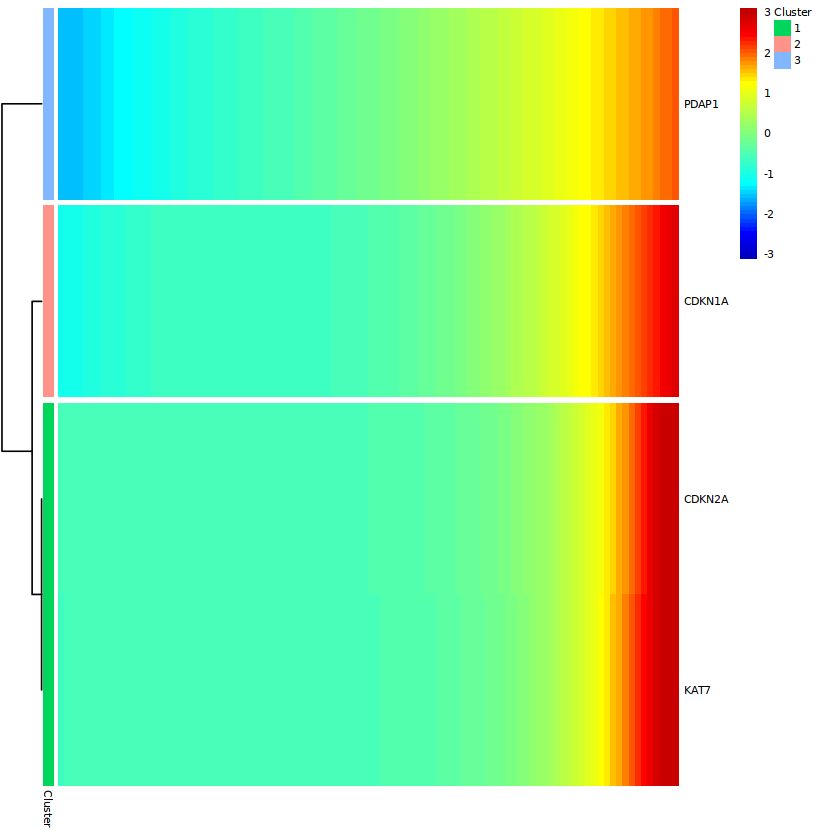

In [11]:
marker_genes=c('CDKN2A','CDKN1A','KAT7','PDAP1','LPA','TERC','TERT','IL6')
diff_test_res <- differentialGeneTest(HSMM_myo[marker_genes,],
              fullModelFormulaStr = "~sm.ns(Pseudotime)")
sig_gene_names <- row.names(subset(diff_test_res, qval < 0.1))
p<-plot_pseudotime_heatmap(HSMM_myo[sig_gene_names,],
                num_clusters = 3,
                cores = 1,
                show_rownames = T)
ggsave("trajectory_genes.pdf", p, width = 12, height = 10, units = "in")

Warning message in if (progenitor_method == "duplicate") {:
"the condition has length > 1 and only the first element will be used"
Warning message in if (progenitor_method == "sequential_split") {:
"the condition has length > 1 and only the first element will be used"
Warning message in asMethod(object):
"sparse->dense coercion: allocating vector of size 1.7 GiB"
Warning message:
"`group_by_()` was deprecated in dplyr 0.7.0.
i Please use `group_by()` instead.
i See vignette('programming') for more help
i The deprecated feature was likely used in the dplyr package.
  Please report the issue at <https://github.com/tidyverse/dplyr/issues>."
Removing 541 outliers



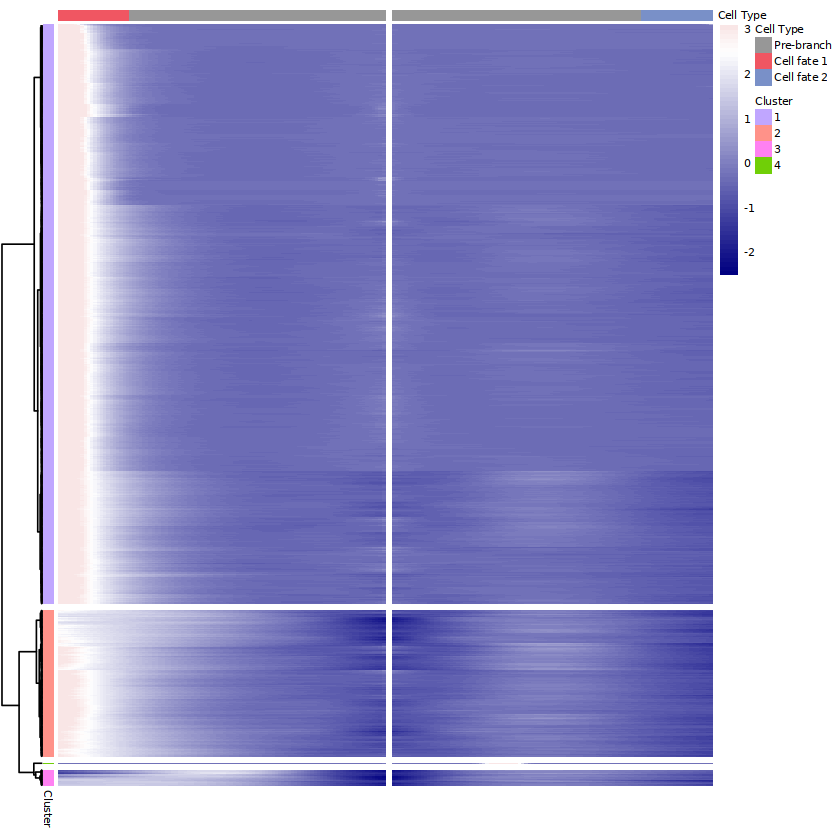

In [12]:
BEAM_res <- BEAM(HSMM_myo, branch_point = 1, cores = 1)
BEAM_res <- BEAM_res[order(BEAM_res$qval),]
BEAM_res <- BEAM_res[,c("fd", "pval", "qval")]
HSMM_myo <- estimateDispersions(HSMM_myo)
plot_genes_branched_heatmap(HSMM_myo[row.names(subset(BEAM_res,
                                          qval < 1e-6)),],
                                          branch_point = 1,
                                          num_clusters = 4,
                                          cores = 1,
                                          use_gene_short_name = T,
                                          show_rownames = F,
                                          hmcols = colorRampPalette(c("navy","white","firebrick3"))(100))

<simpleError in checkwz(wz, M = M, trace = trace, wzepsilon = control$wzepsilon): NAs found in the working weights variable 'wz'>


Warning message in if (x@family@vfamily %in% c("negbinomial", "negbinomial.size")) {:
"the condition has length > 1 and only the first element will be used"


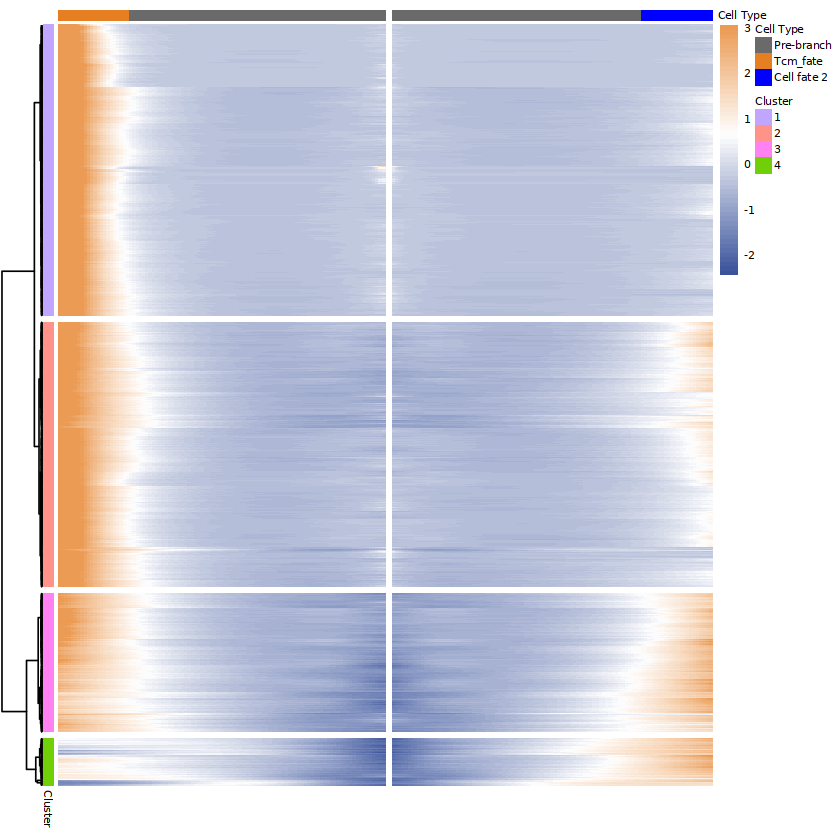

In [14]:
library(grid)
library(pheatmap)
# 修改颜色方案，避免红绿配色
new_colors = colorRampPalette(c("#3A539B", "#FFFFFF", "#E67E22"))(62)

# 修改分支颜色
new_branch_colors = c("#6A6A6A", "#E67E22", "blue")  # 灰色、橙色、蓝色

heatmap_obj=plot_genes_branched_heatmap(
  HSMM_myo[row.names(subset(BEAM_res,qval < 1e-6)),],
  branch_point = 2, 
  num_clusters = 4,
  cores = 1,
  branch_labels = c("Tcm_fate", "Cell fate 2"),
  hmcols = new_colors,
  branch_colors = new_branch_colors,
  use_gene_short_name = T,
  show_rownames = F,
    return_heatmap = T
)

In [ ]:
# 如果heatmap_obj包含pheatmap对象，可以尝试
library(grid)
library(pheatmap)

pdf("branched_heatmap.pdf", width = 8, height = 8)
grid::grid.draw(heatmap_obj$ph_res)  # 假设ph_res是pheatmap对象
dev.off()
# 从热图对象中提取聚类信息
cluster_info <- heatmap_obj$annotation_row$Cluster
head(cluster_info) # 查看前几个基因的聚类情况

# 获取所有基因名称
genes <- rownames(heatmap_obj$annotation_row)

# 为每个聚类创建基因列表
cluster_genes <- list()
for(i in 1:4) { # 您设置了4个聚类
  genes_in_cluster <- genes[cluster_info == i]
  cluster_genes[[paste0("cluster_", i)]] <- genes_in_cluster
}

# 查看每个聚类包含的基因数量
sapply(cluster_genes, length)

# 查看每个聚类的前几个基因
lapply(cluster_genes, head)

# 导出每个聚类的基因到文件
for(i in 1:4) {
  write.table(cluster_genes[[paste0("cluster_", i)]], 
              file = paste0("cluster_", i, "_genes.txt"), 
              quote = FALSE, 
              row.names = FALSE, 
              col.names = FALSE)
}
# 从热图对象中提取聚类信息
cluster_info <- heatmap_obj$annotation_row$Cluster
head(cluster_info) # 查看前几个基因的聚类情况

# 获取所有基因名称
genes <- rownames(heatmap_obj$annotation_row)

# 为每个聚类创建基因列表
cluster_genes <- list()
for(i in 1:4) { # 您设置了4个聚类
  genes_in_cluster <- genes[cluster_info == i]
  cluster_genes[[paste0("cluster_", i)]] <- genes_in_cluster
}

# 查看每个聚类包含的基因数量
sapply(cluster_genes, length)

# 查看每个聚类的前几个基因
lapply(cluster_genes, head)

# 导出每个聚类的基因到文件
for(i in 1:4) {
  write.table(cluster_genes[[paste0("cluster_", i)]], 
              file = paste0("cluster_", i, "_genes.txt"), 
              quote = FALSE, 
              row.names = FALSE, 
              col.names = FALSE)
}

png 
  2

[1] 1 1 1 1 1 1
Levels: 1 2 3 4

cluster_1 cluster_2 cluster_3 cluster_4 
      949       864       452       153

$cluster_1
[1] "IGKC"  "IGHA1" "IGHG2" "IGLC2" "IGHG1" "IGHM" 

$cluster_2
[1] "MALAT1"   "S100A8"   "RASGEF1B" "S100A9"   "SLC26A3"  "CXCR4"   

$cluster_3
[1] "CD74"  "ACTB"  "B2M"   "HLA-B" "HLA-A" "FTH1" 

$cluster_4
[1] "FTL"      "MMP9"     "CST3"     "BEST1"    "ACTG1"    "HLA-DPB1"

[1] 1 1 1 1 1 1
Levels: 1 2 3 4

cluster_1 cluster_2 cluster_3 cluster_4 
      949       864       452       153

$cluster_1
[1] "IGKC"  "IGHA1" "IGHG2" "IGLC2" "IGHG1" "IGHM" 

$cluster_2
[1] "MALAT1"   "S100A8"   "RASGEF1B" "S100A9"   "SLC26A3"  "CXCR4"   

$cluster_3
[1] "CD74"  "ACTB"  "B2M"   "HLA-B" "HLA-A" "FTH1" 

$cluster_4
[1] "FTL"      "MMP9"     "CST3"     "BEST1"    "ACTG1"    "HLA-DPB1"

In [16]:
saveRDS(HSMM_myo, file = "HSMM_myo.rds")

In [22]:
TCA_cycle_genes=c('CS', 'ACLY', 'ACO2', 'ACO1', 'IDH1', 'IDH2', 'IDH3B', 'IDH3G', 'IDH3A', 'OGDHL', 'OGDH', 'DLST', 'DLD', 'SUCLG1', 'SUCLG2', 'SUCLA2', 'SDHA', 'SDHB', 'SDHC', 'SDHD', 'FH', 'MDH1', 'MDH2', 'PC', 'PCK1', 'PCK2', 'PDHA2', 'PDHA1', 'PDHB', 'DLAT', 'PDHX')

In [23]:
p<-plot_cell_trajectory(HSMM_myo,markers=TCA_cycle_genes,
                     use_color_gradient=T)
ggsave("genes_trajectory_TCA_cycle_genes.pdf", p, width = 12, height = 10, units = "in")

In [16]:
Glycolysis_genes=c('HK3', 'HK1', 'HK2', 'HKDC1', 'GCK', 'GPI', 'PFKM', 'PFKP', 'PFKL', 'FBP1', 'FBP2', 'ALDOC', 'ALDOA', 'ALDOB', 'TPI1', 'GAPDH', 'GAPDHS', 'PGK2', 'PGK1', 'PGAM1', 'PGAM2', 'PGAM4', 'ENO3', 'ENO2', 'ENO1', 'ENO4', 'PKM', 'PKLR', 'PDHA2', 'PDHA1', 'PDHB', 'DLAT', 'DLD', 'PDHX', 'LDHAL6A', 'LDHAL6B', 'LDHA', 'LDHB', 'LDHC', 'ADH1A', 'ADH1B', 'ADH1C', 'ADH7', 'ADH4', 'ADH5', 'ADH6', 'AKR1A1', 'ALDH2', 'ALDH3A2', 'ALDH1B1', 'ALDH7A1', 'ALDH9A1', 'ALDH3B1', 'ALDH3B2', 'ALDH1A3', 'ALDH3A1', 'ACSS1', 'ACSS2', 'GALM', 'PGM1', 'PGM2', 'G6PC', 'G6PC2', 'G6PC3', 'ADPGK', 'BPGM', 'MINPP1', 'PCK1', 'PCK2')

In [20]:
p<-plot_cell_trajectory(HSMM_myo,markers=Glycolysis_genes,
                     use_color_gradient=T)
ggsave("genes_trajectory_Glycolysis_genes.pdf", p, width = 15, height = 12, units = "in")

In [18]:
Pentose_phosphate_genes=c('GPI', 'G6PD', 'PGLS', 'H6PD', 'PGD', 'RPE', 'RPEL1', 'TKT', 'TKTL2', 'TKTL1', 'TALDO1', 'RPIA', 'DERA', 'RBKS', 'PGM1', 'PGM2', 'PRPS1L1', 'PRPS2', 'PRPS1', 'RGN', 'IDNK', 'GLYCTK', 'ALDOC', 'ALDOA', 'ALDOB', 'FBP1', 'FBP2', 'PFKM', 'PFKP', 'PFKL')

In [21]:
p<-plot_cell_trajectory(HSMM_myo,markers=Pentose_phosphate_genes,
                     use_color_gradient=T)
ggsave("genes_trajectory_Pentose_phosphate.pdf", p, width = 15, height = 12, units = "in")

In [ ]:
Fatty acid biosynthesis=c('ACACA', 'ACACB', 'MCAT', 'FASN', 'OXSM', 'OLAH     ', 'ACSL6     ', 'ACSL4     ', 'ACSL1     ', 'ACSL5     ', 'ACSL3     ', 'ACSBG1     ', 'ACSBG2     ')

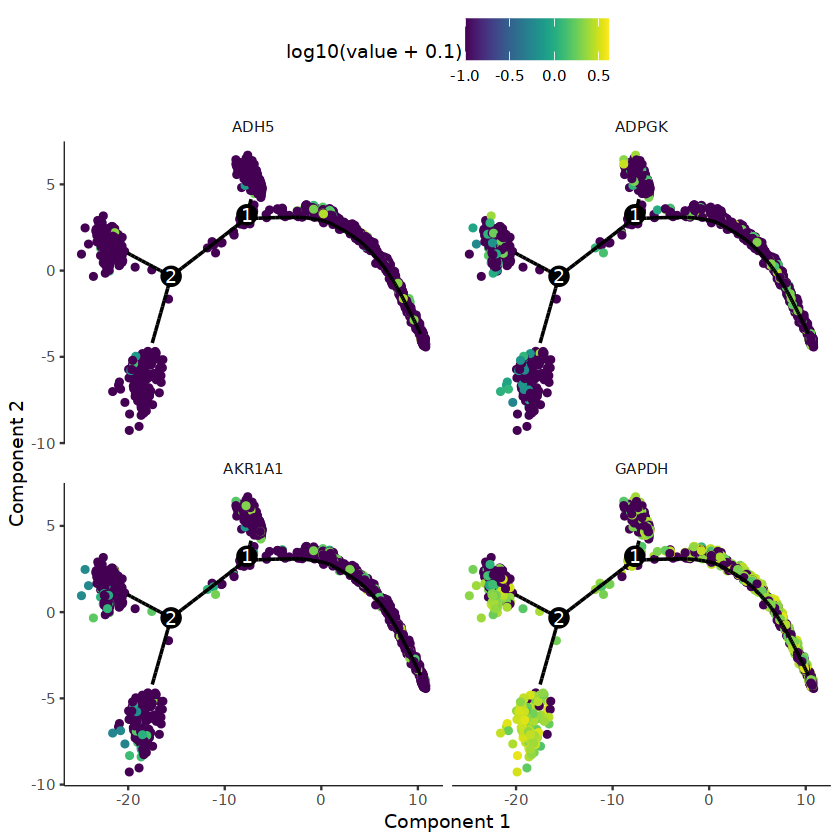

In [41]:
plot_cell_trajectory(HSMM_myo,markers=marker_genes,
                     use_color_gradient=T)

In [30]:
marker

<0 x 0 matrix>

In [5]:
# 加载 ggplot2 包
library(ggplot2)

# 生成第一个图
p1 <- plot_cell_trajectory(HSMM_myo, color_by = "annotation2")

# 保存第一个图
ggsave("/data/work/paper/monocle/trajectory_plot_annotation2.png", plot = p1, width = 8, height = 6, dpi = 300)

# 生成第二个图
p2 <- plot_cell_trajectory(HSMM_myo, color_by = "annotation2") +
  facet_wrap(~State, nrow = 1)

# 保存第二个图
ggsave("/data/work/paper/monocle/trajectory_plot_annotation2_facet.png", plot = p2, width = 10, height = 6, dpi = 300)

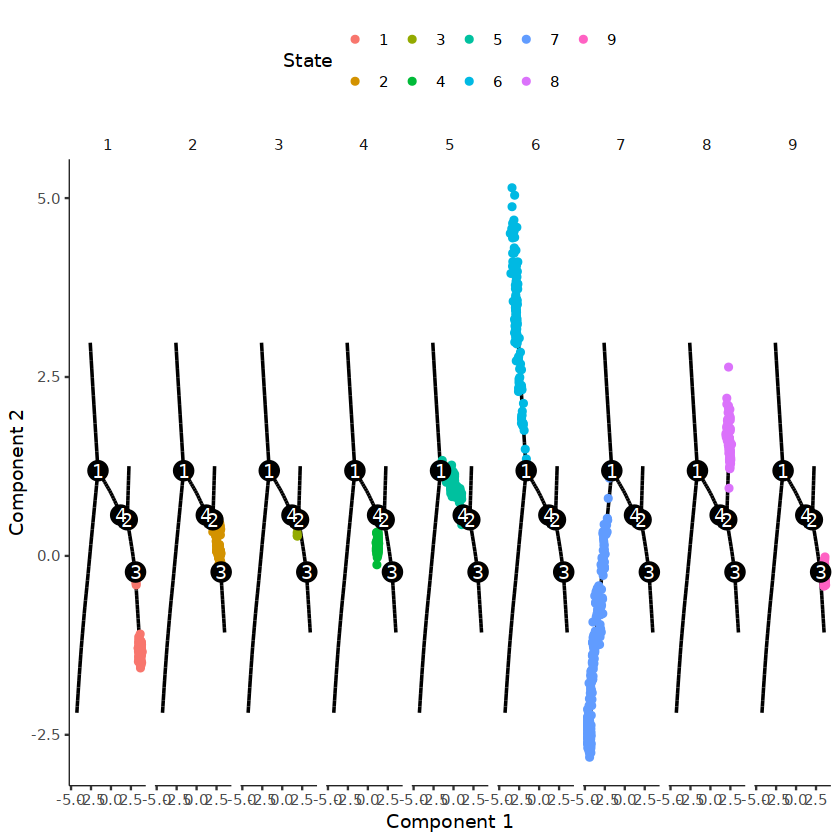

In [6]:
plot_cell_trajectory(HSMM_myo, color_by = "State") +
    facet_wrap(~State, nrow = 1)

In [11]:
disp_table <- dispersionTable(HSMM_myo)
ordering_genes <- subset(disp_table,
                  mean_expression >= 0.5 &
                  dispersion_empirical >= 1 * dispersion_fit)$gene_id

Warning message in dispersionTable(HSMM_myo):
"Warning: estimateDispersions only works, and is only needed, when you're using a CellDataSet with a negbinomial or negbinomial.size expression family"


ERROR: Error in dispersionTable(HSMM_myo): Error: no dispersion model found. Please call estimateDispersions() before calling this function


In [14]:
to_be_tested <- row.names(subset(fData(HSMM_myo),gene_short_name %in% c('CDKN2A','CDKN1A','KAT7','PDAP1','LPA','TERC','TERT','IL6')))
cds_subset <- HSMM_myo[to_be_tested,]

In [15]:
diff_test_res <- differentialGeneTest(cds_subset,
fullModelFormulaStr = "~sm.ns(Pseudotime)")

In [16]:
diff_test_res[,c("gene_short_name", "pval", "qval")]

,gene_short_name,pval,qval
,<chr>,<dbl>,<dbl>
CDKN1A,CDKN1A,1.063823e-39,8.510587e-39
CDKN2A,CDKN2A,7.749728e-01,8.118471e-01
IL6,IL6,1.701771e-02,2.722833e-02
KAT7,KAT7,1.504320e-02,2.722833e-02
LPA,LPA,8.118471e-01,8.118471e-01
PDAP1,PDAP1,1.522795e-05,6.091179e-05
TERC,TERC,2.367073e-03,6.312195e-03
TERT,TERT,7.293390e-01,8.118471e-01


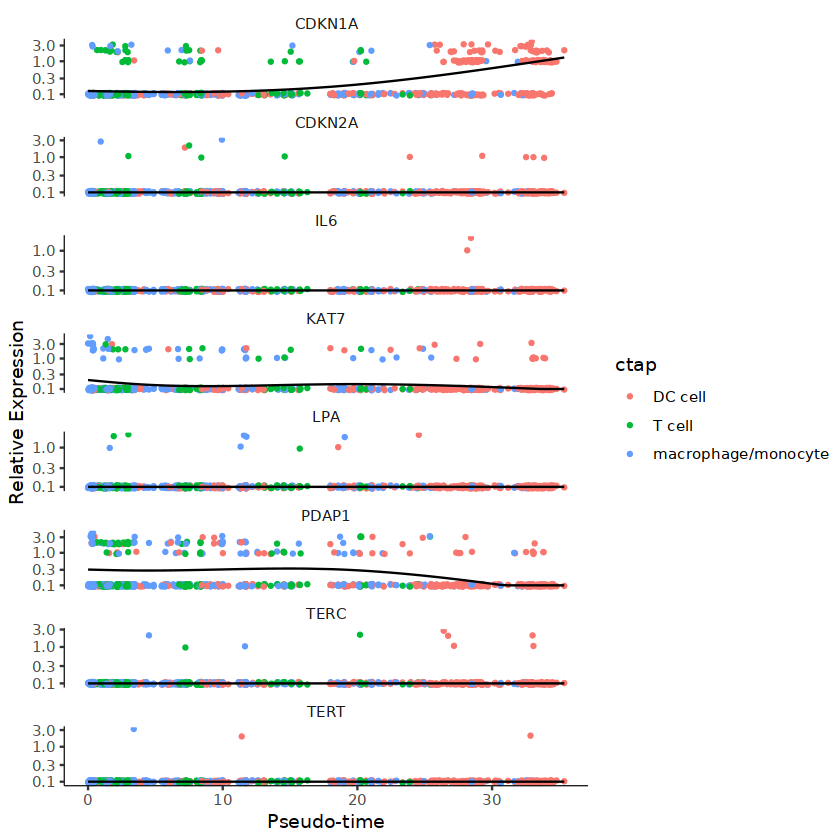

In [21]:
plot_genes_in_pseudotime(cds_subset, color_by = "ctap")

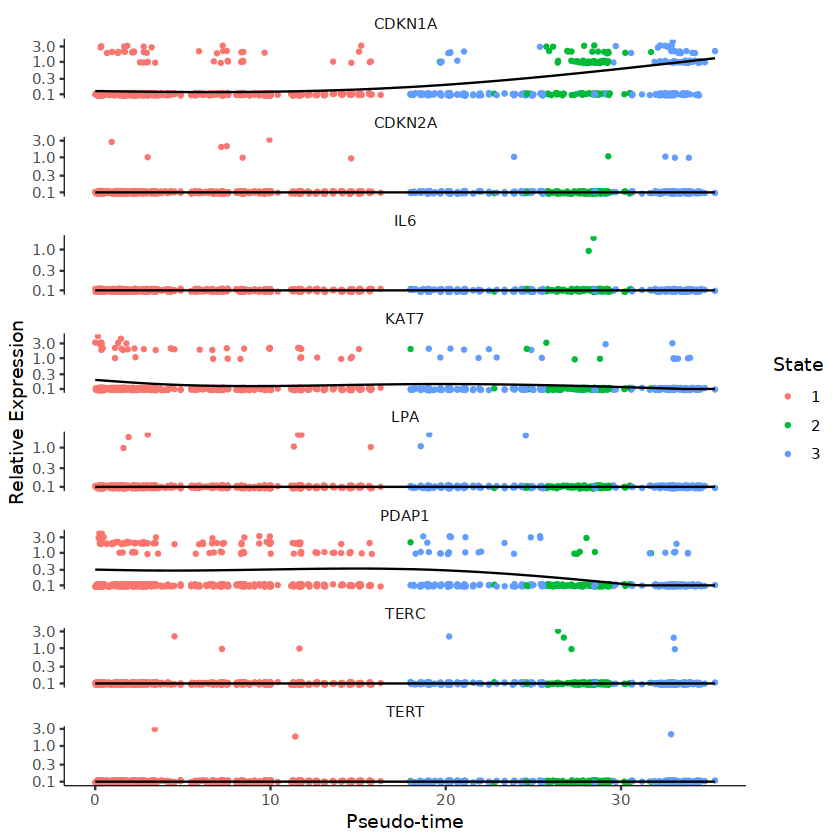

In [17]:
plot_genes_in_pseudotime(cds_subset, color_by = "State")

In [18]:
marker_genes <- row.names(subset(fData(HSMM_myo),
                   gene_short_name %in% c('CDKN2A','CDKN1A','KAT7','PDAP1','LPA','TERC','TERT','IL6')))

In [19]:
diff_test_res <- differentialGeneTest(HSMM_myo[marker_genes,],
                                      fullModelFormulaStr = "~Media")

# Select genes that are significant at an FDR < 10%
sig_genes <- subset(diff_test_res, qval < 0.1)

sig_genes[,c("gene_short_name", "pval", "qval")]

ERROR: Error in `[.data.frame`(pd, , i): undefined columns selected


In [20]:
marker_genes

[1] "CDKN1A" "CDKN2A" "IL6"    "KAT7"   "LPA"    "PDAP1"  "TERC"   "TERT"

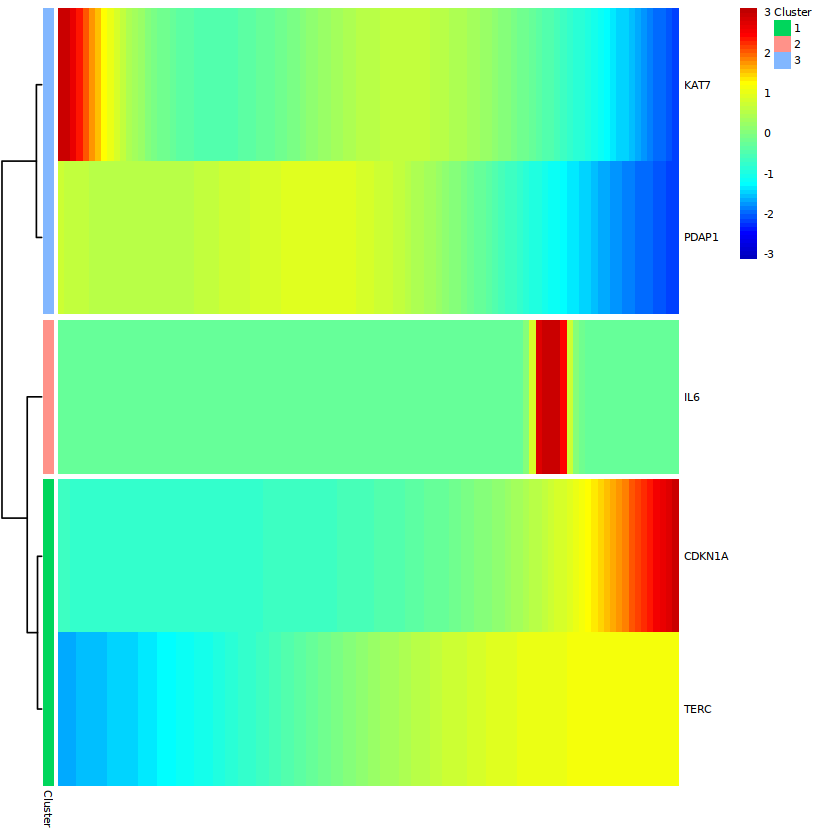

In [22]:
diff_test_res <- differentialGeneTest(HSMM_myo[marker_genes,],
              fullModelFormulaStr = "~sm.ns(Pseudotime)")
sig_gene_names <- row.names(subset(diff_test_res, qval < 0.1))
plot_pseudotime_heatmap(HSMM_myo[sig_gene_names,],
                num_clusters = 3,
                cores = 1,
                show_rownames = T)

In [3]:
BEAM_res <- BEAM(HSMM_myo, branch_point = 1, cores = 1)
BEAM_res <- BEAM_res[order(BEAM_res$qval),]
BEAM_res <- BEAM_res[,c("gene_short_name", "pval", "qval")]

Warning message in if (progenitor_method == "duplicate") {:
"the condition has length > 1 and only the first element will be used"
Warning message in if (progenitor_method == "sequential_split") {:
"the condition has length > 1 and only the first element will be used"


ERROR: Error in `[.data.frame`(BEAM_res, , c("gene_short_name", "pval", "qval")): undefined columns selected


In [ ]:
plot_genes_branched_heatmap(lung[row.names(subset(BEAM_res,
                                          qval < 1e-4)),],
                                          branch_point = 1,
                                          num_clusters = 4,
                                          cores = 1,
                                          use_gene_short_name = T,
                                          show_rownames = T)

In [4]:
colnames(BEAM_res)

[1] "status" "family" "pval"   "qval"   "fd"

In [3]:
cds_DGT_pseudotimegenes <- differentialGeneTest(cds,fullModelFormulaStr = "~sm.ns(Pseudotime)")
#这里完全是为了展示较少的基因所以控制了阈值，实际需要展示什么基因，自己选择
cds_DGT_pseudotimegenes_sig <- subset(ds_DGT_pseudotimegenes, qval < 0.01)

ERROR: Error in `[.data.frame`(pd, , i): undefined columns selected


In [2]:
if(!file.exists(dd)){
  diff_test_res <- differentialGeneTest(sc_cds,
                                        fullModelFormulaStr = " ~ celltype + orig.ident", 
                                        reducedModelFormulaStr = " ~ orig.ident", 
                                        cores = 4)
  save(diff,file = dd)
}

ERROR: Error in file.exists(dd): object 'dd' not found


In [ ]:
gene_to_cluster = diff_test_res %>% 
  arrange(qval) %>% 
  head(50) %>% 
  pull(gene_short_name)
head(gene_to_cluster)
 
plot_pseudotime_heatmap(sc_cds[gene_to_cluster,],
                        num_clusters = nlevels(Idents(scRNA)), 
                        show_rownames = TRUE,
                        cores = 4,return_heatmap = TRUE,
                        hmcols = colorRampPalette(c("navy", "white", "firebrick3"))(100))